In [ ]:
"""
    - https://huggingface.co/datasets/sonnetechnology/license-plate-text-recognition-full
    - https://huggingface.co/microsoft/Florence-2-large
    - https://huggingface.co/qualcomm/EasyOCR
"""

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision import transforms as T
from torch import nn
from torch.nn import functional as F
from torchvision.ops import sigmoid_focal_loss
import cv2

from unet import UNET
from plate_recognition import get_plate, enhance_plate_image

In [2]:
import os
os.environ["HIP_VISIBLE_DEVICES"] = "1" # Keep this line for good measure, it might help with some internal ROCm ops.

import torch

print(f"HIP_VISIBLE_DEVICES (from os.environ): {os.environ.get('HIP_VISIBLE_DEVICES')}")
print(torch.cuda.is_available())
print(torch.cuda.device_count())

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

    # THIS IS THE CRUCIAL CHANGE: Explicitly select device 1
    my_device = torch.device("cuda:0")
    print(f"\nUsing explicit device: {my_device}")

else:
    my_device = torch.device("cpu")
    print("\nCUDA/ROCm not available, falling back to CPU.")

HIP_VISIBLE_DEVICES (from os.environ): 1
False
0

CUDA/ROCm not available, falling back to CPU.


In [ ]:
#  =================================== Dataset Images ===================================

In [3]:
# !pip install datasets
import datasets

ds = datasets.load_dataset("sonnetechnology/license-plate-text-recognition-full")

c:\Users\pc\Desktop\mis\unet_patent_detector\venv_unet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Example image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303 at 0x228BBC01750>


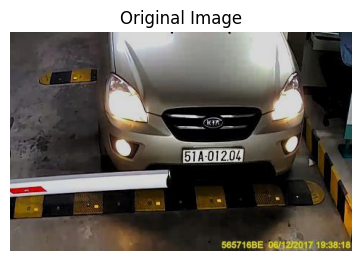

In [4]:
example = ds['train'][np.random.randint(0, len(ds['train']) - 1)]

print(f"Example image: {example['image']}")
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(example['image'])
plt.title('Original Image')
plt.axis('off')

plt.show()

In [5]:
model = UNET(channels_in=3, channels=32, num_classes=1)

In [6]:

# model.load_state_dict(torch.load('model8c_5e_ce.pt', weights_only=False,map_location='cuda:0'))
model.load_state_dict(torch.load('model16c_50e_bcelog_state_dict.pt', weights_only=False, map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
plate, original, mask = get_plate(example['image'], model, 224, 0.7, 0.9, my_device, margin=20)


Mask shape: (224, 224)
Mask min/max values: 0.000/0.998
Bounding box - xmin: 113, xmax: 151, ymin: 121, ymax: 132


In [19]:
enhanced_plate = enhance_plate_image(plate)

In [16]:
def plot_images(original, mask, plate, enhanced_plate):
    print(f"Extracted plate shape: {plate.shape}")
    
    plt.figure(figsize=(20, 5))

    plt.subplot(141) 
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(142) 
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(143)  
    plt.imshow(plate[0].permute(1, 2, 0).numpy())
    plt.title('Extracted Plate')
    plt.axis('off')

    plt.subplot(144) 
    plt.imshow(enhanced_plate, cmap='gray') 
    plt.title('Enhanced Plate')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Extracted plate shape: torch.Size([1, 3, 52, 79])


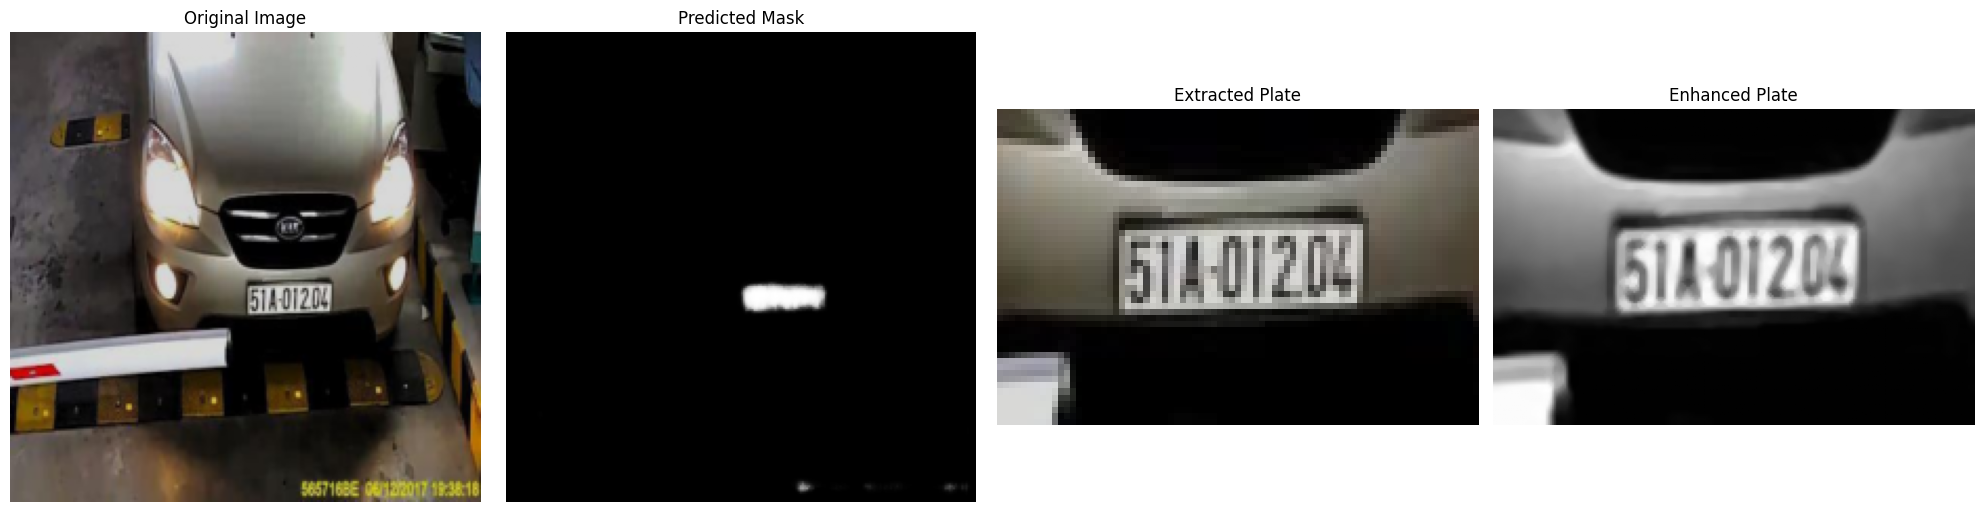

In [20]:

plot_images(original, mask, plate, enhanced_plate)

In [ ]:
#  =================================== Easy OCR ===================================

In [21]:
#  =================================== Easy OCR ===================================

# Install: pip install easyocr
import easyocr
import numpy as np
from PIL import Image

In [22]:
# Initialize EasyOCR reader
# reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())  # Use GPU if available
reader = easyocr.Reader(['en'], gpu=False)  # Use GPU if available


Using CPU. Note: This module is much faster with a GPU.


In [25]:
def detect_plate_text(image, model, device=my_device, confidence_threshold=0.5):
    """
    Complete pipeline: Extract license plate from image and return detected text as string
    
    Args:
        image: PIL Image or image path (string)
        model: Trained UNET model
        device: torch device (cuda/cpu)
        confidence_threshold: Minimum confidence for OCR results
    
    Returns:
        str: Detected text from license plate, or empty string if no text found
    """
    try:
        print(f"type of image: {type(image)}")
        if isinstance(image, str):
            image = Image.open(image)
        
        plate, original, mask = get_plate(image, model, 224, 0.7, 0.9, device)

        enhanced_plate = enhance_plate_image(plate)
        
        if plate is None:
            return ""
        
        plate_img = plate[0].permute(1, 2, 0).numpy()
        if plate_img.max() <= 1.0:
            plate_img = (plate_img * 255).astype(np.uint8)
        else:
            plate_img = plate_img.astype(np.uint8)
        
        results = reader.readtext(plate_img)

        print(f"results: {results}")

        detected_texts = [result[1] for result in results if result[2] > confidence_threshold]
        
        final_text = " ".join(detected_texts).strip()
        
        plot_images(original, mask, plate, enhanced_plate)

        return final_text
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return ""

type of image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Mask shape: (224, 224)
Mask min/max values: 0.000/0.998
Bounding box - xmin: 113, xmax: 151, ymin: 121, ymax: 132
results: [([[np.int32(9), np.int32(9)], [np.int32(53), np.int32(9)], [np.int32(53), np.int32(25)], [np.int32(9), np.int32(25)]], '620', np.float64(0.5461999352956574))]
Extracted plate shape: torch.Size([1, 3, 32, 59])


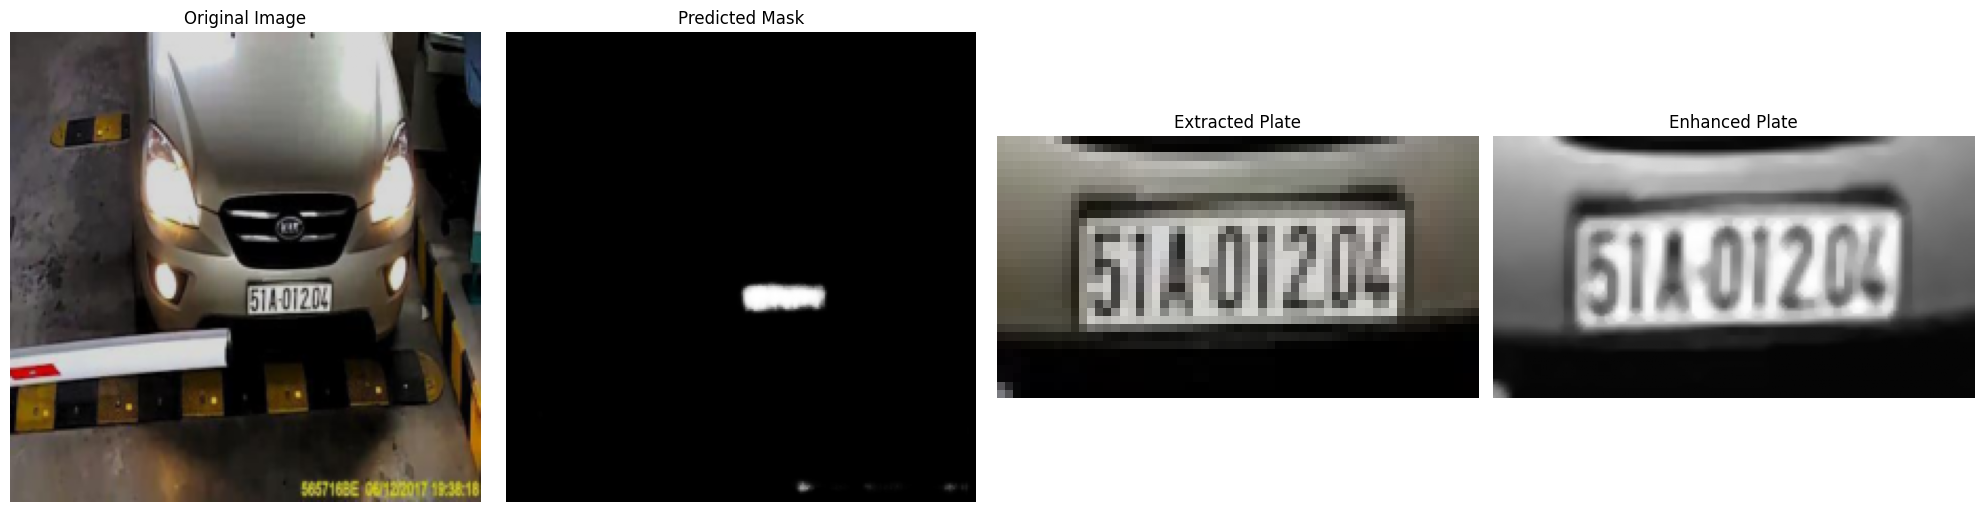

Detected text: ''


In [27]:

text = detect_plate_text(example['image'], model, my_device, confidence_threshold=0.9)
print(f"Detected text: '{text}'")


In [ ]:
"""
Mask shape: (288, 288)
Mask min/max values: 0.000/0.994
Bounding box - xmin: 138, xmax: 191, ymin: 132, ymax: 147
"""